In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# from cmcrameri import cm
# from statsmodels.formula.api import ols
from scipy.special import ndtr
from scipy.optimize import curve_fit, differential_evolution
# from scipy.stats import linregress, ttest_rel, spearmanr, shapiro, sem
# from pathlib import Path
from math import sqrt
# from math import log, e

# N=100

## MLP

In [38]:
# loading results:
import pandas as pd
file_path = r"..\results\MLP_experiment_N100_2024-04-24_17-29-00\MLP\MLP_N100_results.csv"
df_MLP = pd.read_csv(file_path)
df_MLP


,clique size,fraction correct
0,70,1.00000
1,69,1.00000
2,68,1.00000
3,67,1.00000
4,66,1.00000
...,...,...
65,5,0.37500
66,4,0.59375
67,3,0.43750
68,2,0.56250


## CNN

In [39]:
# loading results:
import pandas as pd
file_path = r"..\results\CNN_experiment_N100_2024-04-24_17-38-45\CNN\CNN_N100_results.csv"
df_CNN = pd.read_csv(file_path)
df_CNN


,clique size,fraction correct
0,70,1.00000
1,69,1.00000
2,68,1.00000
3,67,1.00000
4,66,1.00000
...,...,...
65,5,0.50000
66,4,0.43750
67,3,0.43750
68,2,0.34375


## VGG

In [40]:
# loading results:
import pandas as pd
file_path = r"..\results\VGG_experiment_N100_2024-04-24_17-42-48\VGG16\VGG16_N100_results.csv"
df_VGG = pd.read_csv(file_path)
df_VGG

,clique size,fraction correct
0,70,1.00000
1,69,1.00000
2,68,1.00000
3,67,1.00000
4,66,0.96875
...,...,...
65,5,0.50000
66,4,0.46875
67,3,0.53125
68,2,0.40625


Comparison plot for N=100:

Text(0.5, 1.0, 'Comparison of the models for N=100')

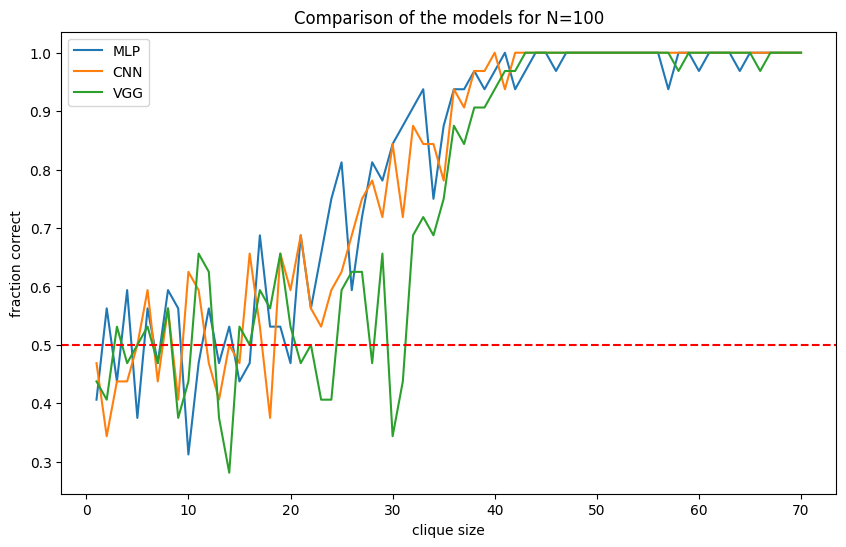

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# creating plot for comparison:
plt.figure(figsize=(10, 6))
# adding data from the different models to the same plot using matplotlib:
# - MLP
sns.lineplot(data=df_MLP, x=df_MLP['clique size'], y=df_MLP['fraction correct'], label='MLP')
# - CNN
sns.lineplot(data=df_CNN, x=df_CNN['clique size'], y=df_CNN['fraction correct'], label='CNN')
# - VGG
sns.lineplot(data=df_VGG, x=df_VGG['clique size'], y=df_VGG['fraction correct'], label='VGG')
# - horizontal dashed line at 0.5:
plt.axhline(y=0.5, color='red', linestyle='--')
# set title:
plt.title("Comparison of the models for N=100")

## Fitting the data with sigmoid function

In [43]:
# Add the "model" column to each dataframe
df_MLP['model'] = 'MLP'
df_CNN['model'] = 'CNN'
df_VGG['model'] = 'VGG'

# Adding k/sqrt(n) variable
df_MLP['k/sqrt(n)'] = df_MLP['clique size'] / sqrt(100)
df_CNN['k/sqrt(n)'] = df_CNN['clique size'] / sqrt(100)
df_VGG['k/sqrt(n)'] = df_VGG['clique size'] / sqrt(100)

# Concatenate the dataframes
df_models = pd.concat([df_MLP, df_CNN, df_VGG], ignore_index=True)

# rename variable "clique size" to "K"
df_models.rename(columns={'clique size': 'k'}, inplace=True)

# Print the concatenated dataframe
df_models


,k,fraction correct,model,k/sqrt(n)
0,70,1.00000,MLP,7.0
1,69,1.00000,MLP,6.9
2,68,1.00000,MLP,6.8
3,67,1.00000,MLP,6.7
4,66,1.00000,MLP,6.6
...,...,...,...,...
205,5,0.50000,VGG,0.5
206,4,0.46875,VGG,0.4
207,3,0.53125,VGG,0.3
208,2,0.40625,VGG,0.2


In [48]:
# defining the sigmoid function to fit to the data:
def sigmoid(k, k0, delta):
    return (1+ndtr((k-k0)/delta))/2
# creating unique array and populating it:
fitted_params_models = []
for df in [df_MLP, df_CNN, df_VGG]:
    fitted_params_models.append(curve_fit(sigmoid, df['clique size'], df['fraction correct'], p0=(70, 20))[0])
print(fitted_params_models)  

# put these into a dataframe:
df_fitted_params_models = pd.DataFrame(fitted_params_models, columns=['k0', 'delta'])
df_fitted_params_models['model'] = ['MLP', 'CNN', 'VGG']  
df_fitted_params_models

[array([27.40006592,  7.78344133]), array([28.94790989,  7.87114179]), array([34.85415098,  3.55898555])]


,k0,delta,model
0,27.400066,7.783441,MLP
1,28.947910,7.871142,CNN
2,34.854151,3.558986,VGG


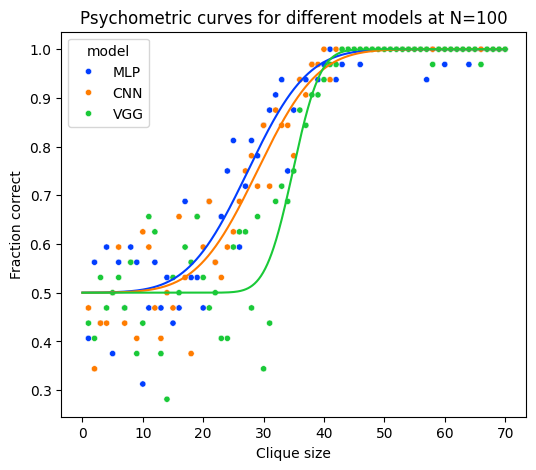

In [50]:
# Create a larger figure with specified size
fig, ax = plt.subplots(figsize=(6, 5))

# defining model names
model_names = ['MLP', 'CNN', 'VGG']

# defining x values
x_vals = np.linspace(0, 70, 1000)

# creating palette for the graph
my_palette_models = sns.color_palette("bright", len(model_names))

# Scatter plot based on unique dataframe:
sns.scatterplot(data=df_models, x='k', y='fraction correct', hue='model', palette=my_palette_models, ax=ax, s=20)

# defining y values for each N value and plotting it
for index, model in enumerate(model_names):
    y_vals = (1 + ndtr((x_vals - fitted_params_models[index][0]) / fitted_params_models[index][1])) / 2
    ax.plot(x_vals, y_vals, color=my_palette_models[index])

# setting labels
# ax.set_xlim(ax.get_xlim()[0], 80)
# ax.set_ylim(0.2, 1.03)
ax.set_ylabel("Fraction correct")
ax.set_xlabel("Clique size")    
ax.tick_params(axis='x')
ax.tick_params(axis='y')
ax.set_title("Psychometric curves for different models at N=100")

# # Remove y ticks that have no meaning
# yticks = ax.get_yticks()
# yticks = [tick for tick in yticks if tick <= 1]
# ax.set_yticks(yticks)

# # Change legend name to "number of nodes"
# handles, labels = ax.get_legend_handles_labels()
# legend = ax.legend(handles, labels, title="Number of nodes", loc='lower right')

# # Drawing K0 and delta for N=1000
# line_x = fitted_params_machines[7][0]
# line_color = my_palette_models[1]
# y_vals = (1 + ndtr((x_vals - fitted_params_machines[7][0]) / fitted_params_machines[7][1])) / 2
# line_y = np.interp(line_x, x_vals, y_vals)

# # Draw vertical dashed line that stops at the curve
# ax.plot([line_x, line_x], [0, line_y], color=my_palette_models[7], linestyle='--', label='K0')

# # Add label "K0" next to the vertical line
# ax.text(130, 0.5, 'K₀', color=my_palette_models[7], ha='left', va='top')

# # Add horizontal error bar
# delta_bar_width = fitted_params_machines[7][1]
# ax.errorbar(line_x, line_y, xerr=delta_bar_width/2, color=my_palette_models[7], capsize=3)

# # Add label "delta" next to the vertical line
# ax.text(160, 0.74, r'$\Delta$', color=my_palette_models[7], ha='left', va='bottom')

# # Decrease scatter plot marker size
# scatter_collection = ax.collections[0]
# scatter_collection.set_sizes([15])

# saving figure in folder "figures" with 300dpi
fig.savefig('../results/plots/single_experiments_N100_2024-04-24/models_comparison_fc_over_k.png', dpi=300)

# Show the plot
plt.show()